# Predicting Asset Changes after elections

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("white")
sns.set_context("poster")

from sklearn import preprocessing

## Cleaning and data pre-procesing

First we load all the available data

In [2]:
sid = pd.read_csv("candidates_final.csv")
sid.loc[:,'url'] = pd.Series(sid['full_link'], index=sid.index); # we create a url variable to merge with matias and anne
matias = pd.read_csv("liabilities.csv")
anne1 = pd.read_csv("movassets.csv")
anne2 = pd.read_csv("immovassets.csv")

Now we merge all the data sets

In [3]:
tmp = pd.merge(sid,matias, on='url')
tmp = pd.merge(tmp,anne1, on='url')
tmp = pd.merge(tmp,anne2, on='url')
len(tmp)

19134

We load the candidates who have participated in multiple elections

In [4]:
med = pd.read_csv("multiple_elections.csv")
med.loc[:,'url'] = pd.Series(med['elec_link'], index=med.index);

We merge the data and then we create a new data set with the most relevant variables

In [7]:
# Merging data
mer = pd.merge(med,tmp, left_on='url', right_on='url')
# Setting url's as index
mer.loc[:,'ind'] = pd.Series(mer['url'], index=mer.index)
idx = mer.set_index('ind')
# Creating a new data frame
df = idx[['url','common_link','Name_y','Year']]
df.columns = ['url','common_link','name','year_elec']
# Adding variables
# Numerical
df.loc[:,'assets'] = pd.Series(idx['Total_Assets'], index=idx.index)
df.loc[:,'liab'] = pd.Series(idx['Total_Liabilities'], index=idx.index)
df.loc[:,'winner'] = pd.Series(idx['Winner'], index=idx.index)
df.loc[:,'age'] = pd.Series(idx['Age_x'], index=idx.index)
df.loc[:,'crim_cases_num'] = pd.Series(idx['Criminal_Cases_y'], index=idx.index)
df.loc[:,'cogniz'] = pd.Series(idx['Cogniz'], index=idx.index)
df.loc[:,'convict'] = pd.Series(idx['Convict'], index=idx.index)
df.loc[:,'framed'] = pd.Series(idx['Framed'], index=idx.index)
df.loc[:,'other_elec'] = pd.Series(idx['Other_elec'], index=idx.index)
df.loc[:,'total_wins'] = pd.Series(idx['Total_Wins'], index=idx.index)
df.loc[:,'history'] = pd.Series(idx['History'], index=idx.index)
# Factor
df.loc[:,'crim_cases_boo'] = pd.Series(idx['Criminal_Cases_x'], index=idx.index).astype('category')
df.loc[:,'educ'] = pd.Series(idx['Education_Level'], index=idx.index).astype('category')
df.loc[:,'party'] = pd.Series(idx['Party_Code'], index=idx.index).astype('category')
df.loc[:,'cons'] = pd.Series(idx['Constituency_x'], index=idx.index).astype('category')
df.loc[:,'state'] = pd.Series(idx['State'], index=idx.index).astype('category')
df.loc[:,'incumbent'] = pd.Series(idx['Incumbent'], index=idx.index).astype('category')
df.dtypes

url                 object
common_link         object
name                object
year_elec            int64
assets               int64
liab                 int64
winner               int64
age                  int64
crim_cases_num       int64
cogniz             float64
convict            float64
framed             float64
other_elec         float64
total_wins         float64
history            float64
crim_cases_boo    category
educ              category
party             category
cons              category
state             category
incumbent         category
dtype: object

We start to create our final data sets

In [8]:
# We segment by the election year
df14 = df[df.year_elec==2014]
df09 = df[df.year_elec==2009]
df04 = df[df.year_elec==2004]
# We create an equity variable
df14.loc[:,'eq'] = df14.assets - df14.liab
df09.loc[:,'eq'] = df09.assets - df09.liab
df04.loc[:,'eq'] = df04.assets - df04.liab
# We measure the growth in equity between two consecutive elections
df1409 =  pd.merge(df14, df09, left_on='common_link', right_on='common_link', suffixes=('_14', '_09') )
df0904 =  pd.merge(df09, df04, left_on='common_link', right_on='common_link', suffixes=('_09', '_04') )

We built an abnormal equity growth indicator (just in case we want to predict it)

In [9]:
# We segment by the election year
df14 = df[df.year_elec==2014]
df09 = df[df.year_elec==2009]
df04 = df[df.year_elec==2004]
# We create an equity variable
df14.loc[:,'eq'] = df14.assets - df14.liab
df09.loc[:,'eq'] = df09.assets - df09.liab
df04.loc[:,'eq'] = df04.assets - df04.liab

# We measure the growth in equity between two consecutive elections
df1409 =  pd.merge(df14, df09, left_on='common_link', right_on='common_link', suffixes=('_14', '_09') )
df0904 =  pd.merge(df09, df04, left_on='common_link', right_on='common_link', suffixes=('_09', '_04') )
# We calculate equity growth
df1409.loc[:,'eqgr'] = df1409.eq_14 / df1409.eq_09 - 1
df0904.loc[:,'eqgr'] = df0904.eq_09 / df0904.eq_04 - 1
# We establish the growth of the country as a reference to measuer abnormal growth in equity
gdp1409 = 1.074*1.069*1.051*1.066*1.103*1.085 - 1
gdp0904 = 1.085*1.038*1.098*1.093*1.093*1.074 - 1
# A factor of magnitude above gdp 
factor = 3.0
# We create the dependent variable that accounts if growth of equity compare to gdp was abnormal or not
df1409['abn_eq_gr'] = np.where(df1409['eqgr'] > gdp1409*factor, 1, 0)
df0904['abn_eq_gr'] = np.where(df0904['eqgr'] > gdp0904*factor, 1, 0)

# Now we clean the variables in both data frames

# For the period 14-09 we drop all the columns asociated with 2014, except the dependent variable 'abn_eq_gr'
to_drop = [x for x in df1409.columns.values if x.endswith('_14')]
to_drop.remove('assets_14'); to_drop.remove('liab_14'); to_drop.remove('eq_14');
df1409.drop(to_drop, axis=1, inplace=True)
df1409.drop('eqgr', axis=1, inplace=True);

# For the period 09-04 we drop all the columns asociated with 2009, except the dependent variable 'abn_eq_gr'
to_drop = [x for x in df0904.columns.values if x.endswith('_09')]
to_drop.remove('assets_09'); to_drop.remove('liab_09'); to_drop.remove('eq_09');
df0904.drop(to_drop, axis=1, inplace=True)
df0904.drop('eqgr', axis=1, inplace=True);

# Now we rename columns so they match
df1409.rename(columns={'assets_14':'assets_nxt_per','liab_14':'liab_nxt_per','eq_14':'eq_nxt_per'}, inplace=True)
df0904.rename(columns={'assets_09':'assets_nxt_per','liab_09':'liab_nxt_per','eq_09':'eq_nxt_per'}, inplace=True)

# Before puting the two data frames together we clean bot suffixes: "_14" and "_09"
for col in df1409:
    if col.endswith('_09'):
        df1409.rename(columns={col:col.rstrip('_09')}, inplace=True)
for col in df0904:
    if col.endswith('_04'):
        df0904.rename(columns={col:col.rstrip('_04')}, inplace=True)

Now we have two separate data frames, df1409 and df0904, for each period. We could treat both periods separately or merge them into one data set, we choose the second option. So, now merge both periods into one data frame and save a csv file in our folder.

In [10]:
# We append both data frames into one data frame and save a csv
data = df1409.append(df0904).reset_index()
data.to_csv("AssetsEquityGrowth.csv", header=True, index=False)

In [11]:
print data.shape
data.head()

(969, 27)


,index,common_link,assets_nxt_per,liab_nxt_per,eq_nxt_per,url,name,year_elec,assets,liab,winner,age,crim_cases_num,cogniz,convict,framed,other_elec,total_wins,history,crim_cases_boo,educ,party,cons,state,incumbent,eq,abn_eq_gr
0,0,http://myneta.info/compare_profile.php?group_i...,9225000,2160000,7065000,http://myneta.info/ls2009/candidate.php?candid...,Mullappally Ramachandran,2009,3316300,502346,1,65,0,0,0,0,4,0,1,No,Post Graduate,INC,Vadakara,16,True,2813954,0
1,1,http://myneta.info/compare_profile.php?group_i...,99602120,4600000,95002120,http://myneta.info/ls2009/candidate.php?candid...,Sudini Jaipal Reddy,2009,56150333,2042919,1,67,0,0,0,0,3,1,1,No,Post Graduate,INC,Chevella,1,True,54107414,0
2,2,http://myneta.info/compare_profile.php?group_i...,35920212,3379297,32540915,http://myneta.info/ls2009/candidate.php?candid...,ANAND PRAKASH PARANJAPE,2009,11998220,3871225,1,36,1,1,0,0,2,0,0,Yes,Post Graduate,SHS,Kalyan,19,False,8126995,1
3,3,http://myneta.info/compare_profile.php?group_i...,535213275,2221000,532992275,http://myneta.info/ls2009/candidate.php?candid...,GUDDU PREMCHAND,2009,105031313,1500000,1,41,3,2,1,0,4,0,2,Yes,5th Pass,INC,Ujjain,18,True,103531313,1
4,4,http://myneta.info/compare_profile.php?group_i...,32275736,4195312,28080424,http://myneta.info/ls2009/candidate.php?candid...,SARVEY SATYANARAYANA,2009,10112521,116848,1,54,1,1,0,0,3,1,1,Yes,Graduate Professional,INC,Malkajgiri,1,True,9995673,1


## Data to predict assets and equity

We create few a variables that we believe could have some predictive power

In [12]:
# Financial leverage
#data.loc[:,'lev'] = data['liab'] / data['eq']
#data.ix[(data['eq']==0) & (data['liab']==0), 'lev'] = 0

# I will take log of assets eq and liab in the dependent variables
def winsor_log(x):
    var = 0
    if x > 0:
        var =np.log(x)
    return var
data.loc[:,'assets_nxt_per'] = data.assets_nxt_per.apply(lambda x: winsor_log(x))
data.loc[:,'liab_nxt_per'] = data.liab_nxt_per.apply(lambda x: winsor_log(x))
data.loc[:,'eq_nxt_per'] = data.eq_nxt_per.apply(lambda x: winsor_log(x))
# I will take log of assets eq and liab in the independent variables
data.loc[:,'assets'] = data.assets.apply(lambda x: winsor_log(x))
data.loc[:,'liab'] = data.liab.apply(lambda x: winsor_log(x))
data.loc[:,'eq'] = data['eq'].apply(lambda x: winsor_log(x))
data.isnull().sum()

# We check that there are no np.nan or null in the data frame
data.isnull().sum()

index             0
common_link       0
assets_nxt_per    0
liab_nxt_per      0
eq_nxt_per        0
url               0
name              0
year_elec         0
assets            0
liab              0
winner            0
age               0
crim_cases_num    0
cogniz            0
convict           0
framed            0
other_elec        0
total_wins        0
history           0
crim_cases_boo    0
educ              0
party             0
cons              0
state             0
incumbent         0
eq                0
abn_eq_gr         0
dtype: int64

In [13]:
data.to_csv("DataForVarSel.csv", header=True, index=False)

We define the data that we are going to treat as numerical, binary and categorical

In [14]:
binary = ['winner','convict','total_wins']
categorical = ['educ','party','cons','state','incumbent','crim_cases_boo']
numerical = ['assets','liab','age','crim_cases_num','history','other_elec','cogniz']

We need to label the data that is categorical so we can use it in the encoders

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [16]:
tmp = MultiColumnLabelEncoder(columns = categorical).fit_transform(data)

We define a function to preprocess categorical and numerical data

In [17]:
"""

This function receives two different parts of the same data frame, one containing the numerical data
and other containing categorical data, then pre-process both data and finally returns only one data frame
with the clean data

"""
def pre_process(data_num, data_cat):
    
    scaler = preprocessing.StandardScaler().fit(data_num)
    enc = preprocessing.OneHotEncoder().fit(data_cat)
    
    data_scaled = scaler.transform(data_num)
    data_encoded = enc.transform(data_cat).toarray()
    
    temp = []
    for x,y in zip(data_scaled, data_encoded):
         temp.append(np.concatenate([x,y]))
    data_clean = pd.DataFrame(temp)
    
    return data_clean

In [18]:
# Just an example of how things look: the data is too sparse
x = pre_process(tmp[numerical], tmp[categorical])
x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666
0,-0.414898,0.786784,1.302437,-0.316220,1.173575,1.539902,-0.315557,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0.979292,0.995579,1.491142,-0.316220,1.173575,0.273208,-0.315557,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,0.218783,1.090715,-1.433790,0.055646,-0.620107,-0.993485,0.056432,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1.287889,0.949601,-0.962027,0.799378,2.967257,1.539902,0.428420,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0.134524,0.569717,0.264557,0.055646,1.173575,0.273208,0.056432,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


# Another approach to categorical data (and the one that we finally used)

Now we are going to do a little of work on our categorical variables. We will keep only categorical variables that have a reasonable amount of levels, for this case we will arbitrarily select 20.

In [19]:
# Education, we drop the "Others" category to avoid colinearity
df_educ = pd.get_dummies(data['educ']).rename(columns = lambda x : 'educ_' + x)
df_educ.drop('educ_Others', axis=1, inplace=True)
# Incumbency
df_incumbent = pd.get_dummies(data['incumbent']).rename(columns = lambda x : 'incumbent_' + x)
df_incumbent.drop('incumbent_False', axis=1, inplace=True)
df_incumbent.rename(columns={'incumbent_True':'incumbent'}, inplace=True)
# State, we will drop state = 37
df_state = pd.get_dummies(data['state']).rename(columns = lambda x : 'state_' + str(x))
df_state.drop('state_37', axis=1, inplace=True)
data_dummies = pd.concat([df_incumbent, df_educ,df_state], axis=1)
data_dummies.head()

,incumbent,educ_10th Pass,educ_12th Pass,educ_5th Pass,educ_8th Pass,educ_Doctorate,educ_Graduate,educ_Graduate Professional,educ_Illiterate,educ_Literate,educ_Not Given,educ_Post Graduate,state_0,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,state_12,state_13,state_14,state_15,state_16,state_17,state_18,state_19,state_20,state_21,state_22,state_24,state_25,state_27,state_28,state_29,state_30,state_31,state_33,state_34,state_35,state_36
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We will separate our numerical data in two types: the variables that we are going to standardize and the ones that we are not.

##  Creating the test and the training set, and standardizing variables

Now we create the training and test set. Is important that highlight that, for now, our data is balanced almost 50/50, so we will just make a simple random sample for the train and test set.

In [20]:
data.describe()

,index,assets_nxt_per,liab_nxt_per,eq_nxt_per,year_elec,assets,liab,winner,age,crim_cases_num,cogniz,convict,framed,other_elec,total_wins,history,state,eq,abn_eq_gr
count,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,258.790506,16.969154,9.050962,16.758041,2007.163055,15.856299,7.840837,0.562436,51.196078,0.850361,0.848297,0.002064,0,2.784314,0.120743,0.345717,19.609907,15.437278,0.498452
std,165.999360,1.713331,7.139885,2.235890,2.411713,2.030314,6.722225,0.496343,10.604008,2.690529,2.689646,0.045408,0,0.789864,0.325997,0.557800,12.307717,3.102007,0.500256
min,0.000000,11.238489,0.000000,0.000000,2004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,121.000000,15.905404,0.000000,15.764440,2004.000000,14.914284,0.000000,0.000000,44.000000,0.000000,0.000000,0.000000,0,2.000000,0.000000,0.000000,10.000000,14.701620,0.000000
50%,242.000000,16.984011,12.921387,16.857158,2009.000000,15.854781,11.580584,1.000000,51.000000,0.000000,0.000000,0.000000,0,3.000000,0.000000,0.000000,19.000000,15.711297,0.000000
75%,370.000000,17.976125,14.865473,17.932611,2009.000000,16.962878,13.764217,1.000000,59.000000,1.000000,1.000000,0.000000,0,3.000000,0.000000,1.000000,34.000000,16.875456,1.000000
max,612.000000,22.567233,21.060267,22.566610,2009.000000,23.707697,19.633327,1.000000,88.000000,46.000000,46.000000,1.000000,0,6.000000,1.000000,3.000000,37.000000,23.707652,1.000000


In [34]:
# First we split into training and test sets, 
mask = np.random.rand(len(data)) <= 0.7

# Now we run the standarization process in the numerical variables for the training and test sets
# scaler_train = preprocessing.StandardScaler().fit(data[mask][numerical])
# scaler_test = preprocessing.StandardScaler().fit(data[~mask][numerical])
# data_scaled_train = pd.DataFrame(data=scaler_train.transform(data[mask][numerical]), columns=numerical, index=data[mask].index)
# data_scaled_test = pd.DataFrame(scaler_test.transform(data[~mask][numerical]), columns=numerical, index=data[~mask].index)
xtrain = pd.concat([data[mask][numerical], data[mask][binary], data_dummies[mask]], axis=1)
xtest = pd.concat([data[~mask][numerical], data[~mask][binary], data_dummies[~mask]], axis=1)
# We denominate the dependendet variables
ytrain_assets = pd.DataFrame(data[mask]['assets_nxt_per'])
ytest_assets = pd.DataFrame(data[~mask]['assets_nxt_per'])
ytrain_eq = pd.DataFrame(data[mask]['eq_nxt_per'])
ytest_eq = pd.DataFrame(data[~mask]['eq_nxt_per'])

In [35]:
print "number of observations in the training set: " + str(len(xtrain))
print "number of observations in the test set: " + str(len(xtest))
print "total observations: " + str(len(xtrain)+len(xtest))

number of observations in the training set: 680
number of observations in the test set: 289
total observations: 969


##  Predicting Assets

Please keep in mind that the sklearn fuction for MSE flips the sign of it:

https://github.com/scikit-learn/scikit-learn/issues/2439

### Baseline

The baseline will be to predict next period assets base on the previous level of assets using a regression

In [36]:
from sklearn import linear_model, cross_validation
from sklearn.metrics import mean_squared_error

xtrain_assets = pd.DataFrame(xtrain['assets'])
xtest_assets = pd.DataFrame(xtest['assets'])
clf_baseline = linear_model.LinearRegression(fit_intercept=True, normalize=False)
scores_baseline = cross_validation.cross_val_score(clf_baseline, xtrain_assets, ytrain_assets, cv=10, scoring='mean_squared_error')
clf_baseline.fit(xtrain_assets,ytrain_assets)
yhat = clf_baseline.predict(xtest_assets)
mse_baseline = mean_squared_error(ytest_assets, yhat)
print "The cross validated MSE mean for the baseline in the train set is: " + str(scores_baseline.mean()*-1.0)
print "The std dev of CV MSE is: " + str(np.std(scores_baseline))
print "The MSE for the baseline in the test sets is: " + str(mse_baseline)

The cross validated MSE mean for the baseline in the train set is: 1.39399346649
The std dev of CV MSE is: 0.91908859978
The MSE for the baseline in the test sets is: 0.843505541202


### Lasso

In [24]:
from sklearn.grid_search import GridSearchCV
alphas = [1, 1e-1, 1e-2, 1e-3, 1e-8, 1e-10, 1e-13, 1e-15]
clf_lasso_cv = linear_model.Lasso(max_iter=100000)
gs = GridSearchCV(clf_lasso_cv, param_grid=dict(alpha=alphas), cv=10, n_jobs=1, scoring = 'mean_squared_error')
gs.fit(xtrain, ytrain_assets)
best = gs.best_estimator_

In [25]:
best.alpha

0.01

In [26]:
from sklearn import linear_model, cross_validation
from sklearn.metrics import mean_squared_error
clf_lasso = linear_model.Lasso(alpha=best.alpha, max_iter=10000)
scores_lasso = cross_validation.cross_val_score(clf_lasso, xtrain, ytrain_assets, cv=5, scoring='mean_squared_error')
clf_lasso.fit(xtrain, ytrain_assets)
yhat = clf_lasso.predict(xtest)
mse_lasso = mean_squared_error(ytest_assets, yhat)
print "The cross validated MSE mean for Lasso in the train set is: " + str(scores_lasso.mean()*-1.0)
print "The std dev of CV MSE is: " + str(np.std(scores_lasso))
print "The MSE for Lasso in the test sets is: " + str(mse_lasso)

The cross validated MSE mean for Lasso in the train set is: 1.39593501105
The std dev of CV MSE is: 0.813617303335
The MSE for Lasso in the test sets is: 0.818028883685


### Linear regression with selected variables

Using stepwise and RF variable selection method in R, we arrived at the following formula:

assests_nxt_per ~ assets + winner + age + other_elec + history + educ

In [27]:
# We build the data with only the variables of interest
var_sel_num = ['assets','winner','age','other_elec','history']
varsel = pd.concat([data[var_sel_num],df_educ], axis=1)
xtrain_varsel = varsel[mask]
xtest_varsel = varsel[~mask]

Now we implement a linear regression

In [28]:
clf_linear = linear_model.LinearRegression(fit_intercept=True)
scores_linear = cross_validation.cross_val_score(clf_linear, xtrain_varsel, ytrain_assets, cv=5, scoring='mean_squared_error')
clf_linear.fit(xtrain_varsel, ytrain_assets)
yhat = clf_linear.predict(xtest_varsel)
mse_linear = mean_squared_error(ytest_assets, yhat)
print "The cross validated MSE mean for the linear regression in the train set is: " + str(scores_linear.mean()*-1.0)
print "The std dev of CV MSE is: " + str(np.std(scores_linear))
print "The MSE for the linear regrssion in the test sets is: " + str(mse_linear)

The cross validated MSE mean for the linear regression in the train set is: 1.41310477929
The std dev of CV MSE is: 0.806194389056
The MSE for the linear regrssion in the test sets is: 0.859091693579


### Random Forest

In [29]:
%%time
from sklearn.ensemble import RandomForestRegressor
max_feat = [3,5,7,10,13,15]
clf_rf_cv = RandomForestRegressor(n_estimators=101)
gs = GridSearchCV(clf_rf_cv, param_grid=dict(max_features=max_feat), cv=10, n_jobs=1, scoring = 'mean_squared_error')
gs.fit(xtrain, ytrain_assets.assets_nxt_per)
best = gs.best_estimator_

CPU times: user 8.42 s, sys: 54.2 ms, total: 8.47 s
Wall time: 8.49 s


In [86]:
%%time
clf_rf = RandomForestRegressor(n_estimators=1001, max_features=best.max_features)
scores_rf = cross_validation.cross_val_score(clf_rf, xtrain, ytrain_assets.assets_nxt_per, cv=5, scoring='mean_squared_error')
clf_rf.fit(xtrain, ytrain_assets.assets_nxt_per)
yhat_rf = clf_rf.predict(xtest)
mse_rf = mean_squared_error(ytest_assets, yhat_rf)
print "The cross validated MSE mean for the random forest in the train set is: " + str(scores_rf.mean()*-1.0)
print "The std dev of CV MSE is: " + str(np.std(scores_rf))
print "The MSE for the random forest in the test sets is: " + str(mse_rf)

The cross validated MSE mean for the random forest in the train set is: 0.833596907698
The std dev of CV MSE is: 0.114756830673
The MSE for the random forest in the test sets is: 0.57579306626
CPU times: user 9.32 s, sys: 96.4 ms, total: 9.41 s
Wall time: 9.44 s


#### Variable importance for the Random Forest (by far the best performer)

In [42]:
feat_list = []
for i,c in enumerate(xtrain.columns):
    feat_imp = {}    
    feat_imp['feature'] = c
    feat_imp['score'] = clf_rf.feature_importances_[i]
    feat_list.append(feat_imp)
var_imp_temp = pd.DataFrame(feat_list)

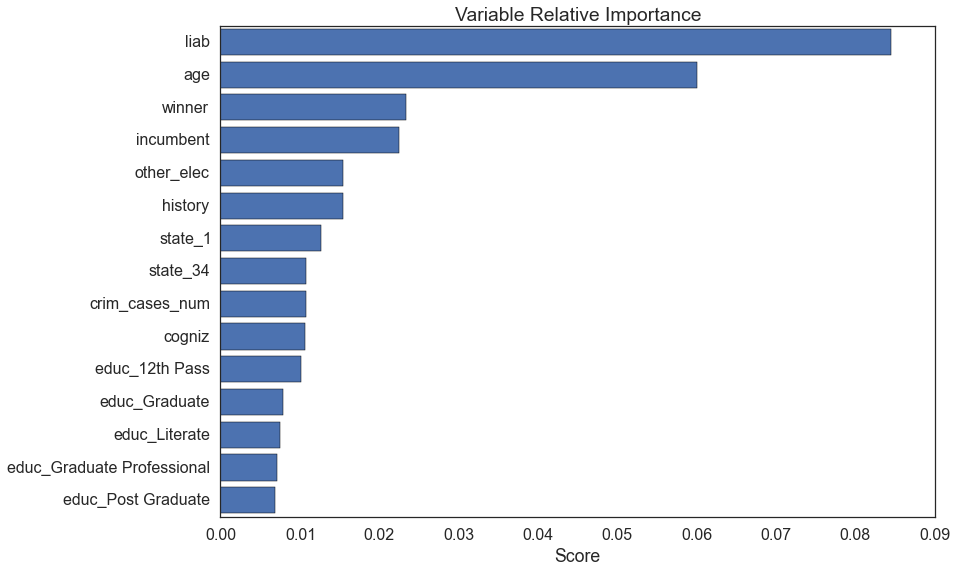

In [43]:
var_imp = var_imp_temp.sort('score', ascending=False).reset_index()
var_imp.drop(['index'], axis=1, inplace=True)
pos = np.arange(15)+.5
val = var_imp['score'][1:16]
var = var_imp['feature'][1:16]
plt.barh(pos,val, align='center')
plt.yticks(pos, np.array(var));
plt.gca().invert_yaxis()
plt.ylim([15,0])
plt.title("Variable Relative Importance")
plt.xlabel("Score")
plt.tight_layout
plt.savefig("figures/RF_Var_Imp.png",dpi=100,format='png',bbox_inches='tight')

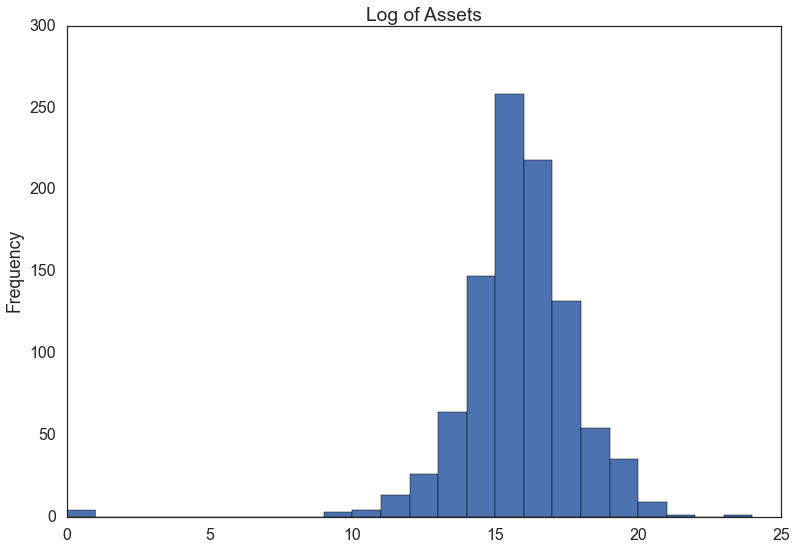

In [49]:
binwidth = 1
plt.hist(data['assets'], bins=np.arange(min(data['assets']), max(data['assets']) + binwidth, binwidth));
plt.title("Log of Assets")
plt.ylabel("Frequency")
plt.tight_layout
plt.savefig("figures/Hist_Log_Assets.png",dpi=100,format='png',bbox_inches='tight')

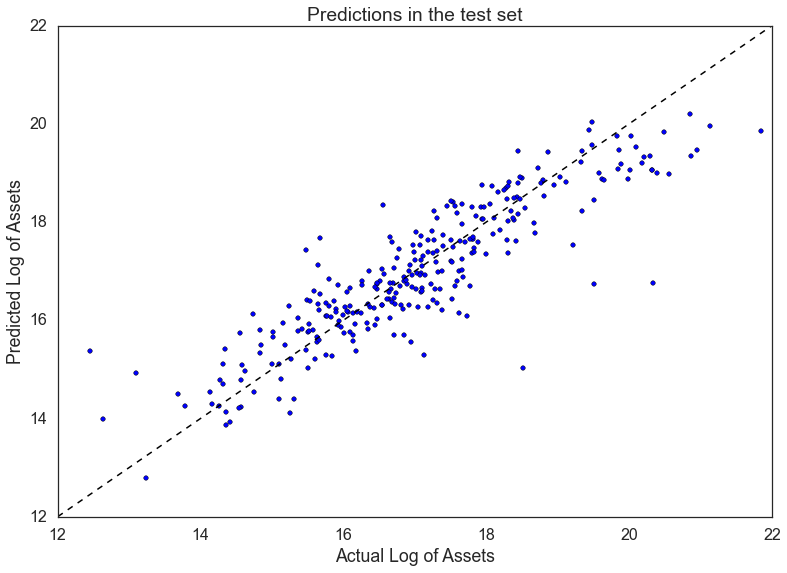

In [109]:
plt.scatter(ytest_assets,yhat_rf)
plt.xlim([12,22])
plt.ylim([12,22])
plt.xlabel("Actual Log of Assets")
plt.ylabel("Predicted Log of Assets")
plt.title("Predictions in the test set")
plt.plot([12,22], [12,22], 'k--', color="black", linewidth=1.5)
plt.savefig("figures/RF_Pred_Test.png",dpi=100,format='png',bbox_inches='tight')

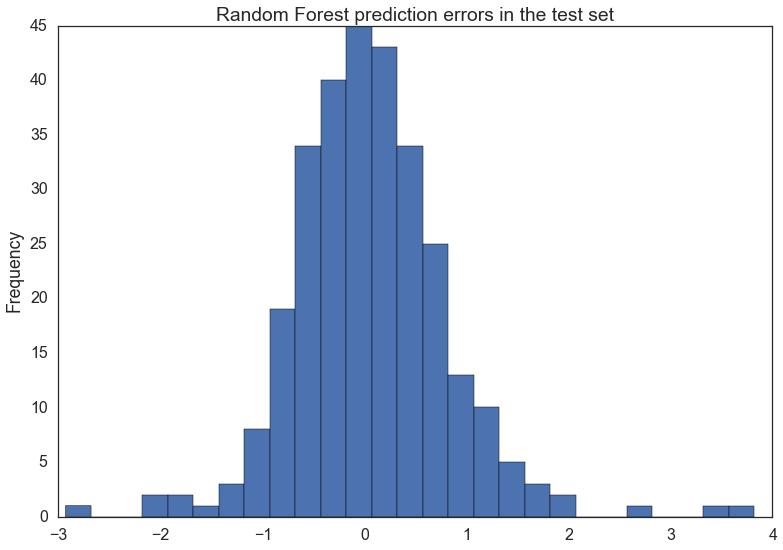

In [107]:
binwidth = 0.25
errors = np.array(ytest_assets.assets_nxt_per - yhat_rf)
plt.hist(errors, bins=np.arange(min(errors), max(errors) + binwidth, binwidth));
plt.title("Random Forest prediction errors in the test set")
plt.ylabel("Frequency")
plt.tight_layout
plt.savefig("figures/RF_Errors.png",dpi=100,format='png',bbox_inches='tight')